# Imports

In [2]:
from pathlib import Path
import torch
from torch import nn
from torch import optim
from torchsummary import summary
from mltrainer import metrics, Trainer, TrainerSettings, ReportTypes
from mltrainer.preprocessors import BasePreprocessor
import mlflow
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.early_stop import no_progress_loss
from hyperopt.pyll import scope
from mads_datasets import DatasetFactoryProvider, DatasetType
from loguru import logger
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Datastreamer

In [4]:
datafactory = DatasetFactoryProvider.create_factory(DatasetType.FASHION)
batchsize = 64
preprocessor = BasePreprocessor()
streamers = datafactory.create_datastreamer(batchsize=batchsize, preprocessor=preprocessor)
train = streamers["train"]
valid = streamers["valid"]
train_streamer = train.stream()
valid_streamer = valid.stream()

2023-12-17 16:03:21.728 | INFO     | mads_datasets.base:download_data:121 - Folder already exists at /home/azureuser/.cache/mads_datasets/fashionmnist
2023-12-17 16:03:21.730 | INFO     | mads_datasets.base:download_data:124 - File already exists at /home/azureuser/.cache/mads_datasets/fashionmnist/fashionmnist.pt


# Model

In [13]:
# Although this program will likely only run on the vm,
# and the vm lacks gpu support, a gpu check is added in case the
# program is ran outside of the vm.

device = "gpu" if torch.cuda.is_available() else "cpu"
print(f"Model training takes place on the {device}")


class CNN(nn.Module):
    def __init__(
        self,
        layers: int = 3,
        units: int = 56,
        filters: int = 32,
        normalization: bool = False,
        dropout: float = 0.0,
        input_size: tuple = (32, 1, 28, 28),
    ):
        super().__init__()

        self.convolutional_blocks = nn.ModuleList()
        for i in range(0, layers):
            first = i == 0
            self.convolutional_blocks.append(
                self._generate_convolutional_layer(filters=filters, normalization=normalization, first=first)
            )

        # In order to solve the potential problem of connecting the image layers
        # with the linear layers, an AvgPool2d is added based on the size of the
        # activationmap from the convolutional layers.
        # Resulting in (batch, activationmaps, 1, 1) before flattening.
        activaton_map_size = self._conv_test(input_size)
        self.aggregated_layer = nn.AvgPool2d(activaton_map_size)

        self.linear_blocks = nn.ModuleList()
        for i in range(0, layers):
            first = i == 0
            last = i == (layers - 1)
            self.linear_blocks.append(
                self._generate_linear_layers(
                    filters=filters,
                    units=units,
                    dropout=dropout,
                    normalization=normalization,
                    first=first,
                    last=last,
                )
            )

    def _generate_convolutional_layer(
        self,
        filters: int, normalization: bool = False, first: bool = False
    ) -> nn.Sequential:
        in_channels = 1 if first else filters
        layers = []
        layers.append(nn.Conv2d(in_channels, filters, kernel_size=3))
        layers.append(nn.BatchNorm2d(filters)) if normalization else None
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2))
        return nn.Sequential(*layers)

    def _conv_test(self, input_size):
        x = torch.ones(input_size)
        for block in self.convolutional_blocks:
            x = block(x)
        return x.shape[-2:]

    def _generate_linear_layers(
        self,
        filters: int,
        units: int,
        dropout: float = 0.0,
        normalization: bool = False,
        first: bool = False,
        last: bool = False,
    ) -> nn.Sequential:
        in_features = filters if first else units
        out_features = 10 if last else units
        layers = []
        layers.append(nn.Flatten()) if first else None
        layers.append(nn.Dropout1d(dropout)) if dropout != 0.0 and last else None
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.BatchNorm1d(units)) if normalization and not last else None
        layers.append(nn.ReLU()) if not last else None
        return nn.Sequential(*layers)

    def forward(self, x):
        for block in self.convolutional_blocks:
            x = block(x)
        x = self.aggregated_layer(x)
        for block in self.linear_blocks:
            x = block(x)
        return x


model = CNN(layers=2, filters=32, units=32, dropout=0.2).to(device)


Model training takes place on the cpu


In [14]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
         MaxPool2d-3           [-1, 32, 13, 13]               0
            Conv2d-4           [-1, 32, 11, 11]           9,248
              ReLU-5           [-1, 32, 11, 11]               0
         MaxPool2d-6             [-1, 32, 5, 5]               0
         AvgPool2d-7             [-1, 32, 1, 1]               0
           Flatten-8                   [-1, 32]               0
            Linear-9                   [-1, 32]           1,056
             ReLU-10                   [-1, 32]               0
        Dropout1d-11                   [-1, 32]               0
           Linear-12                   [-1, 10]             330
Total params: 10,954
Trainable params: 10,954
Non-trainable params: 0
---------------------------------

# Optimizer, loss & accuracy

In [7]:
optimizer = optim.Adam
loss_function = torch.nn.CrossEntropyLoss()
accuracy = metrics.Accuracy()

# MLflow

In [44]:
experiment_path = "MNIST_CNN"
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment(experiment_path)

<Experiment: artifact_location='/home/azureuser/code/ADS-DeepLearning-project/hyper_parameter_exercise/notebook/mlruns/3', creation_time=1702823037046, experiment_id='3', last_update_time=1702823037046, lifecycle_stage='active', name='MNIST_CNN', tags={}>

In [9]:
model_directory = Path("../../models/mnist").resolve()
if not model_directory.exists():
    model_directory.mkdir(parents=True)
    print(f"Created {model_directory}")

In [10]:
trainer_settings = TrainerSettings(
    epochs=3,
    metrics=[accuracy],
    logdir="modellog",
    train_steps=len(train),
    valid_steps=len(valid),
    reporttypes=[ReportTypes.MLFLOW]
)

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "convolutional_network")
        mlflow.set_tag("dev", "tom")
        mlflow.log_params(params)
        mlflow.log_param("batchsize", f"{batchsize}")

        model = CNN(**params)
        trainer = Trainer(
            model=model,
            settings=trainer_settings,
            loss_fn=loss_function,
            optimizer=optimizer,
            traindataloader=train_streamer,
            validdataloader=valid_streamer,
            scheduler=optim.lr_scheduler.ReduceLROnPlateau
        )
        trainer.loop()

        tag = datetime.now().strftime("%Y%m%d-%H%M")
        model_path = model_directory / (tag + "model.pt")
        torch.save(model, model_path)

        mlflow.log_artifact(local_path=model_path, artifact_path="pytorch_models")
        
        return {"loss": trainer.test_loss, "status": STATUS_OK}

In [11]:
search_space = {
    "layers": scope.int(hp.quniform("layers", 2, 3, 1)),
    "units": scope.int(hp.quniform("units", 32, 64, 8)),
}

In [20]:
search_space = {
    "filters": scope.int(hp.quniform("filters", 32, 128, 8)),
    "normalization": scope.int(hp.choice("normalization", [True, False])),
}

In [ ]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=100,
    trials=Trials(),
    early_stop_fn=no_progress_loss(10)
)

In [22]:
best_result

{'filters': 104.0, 'normalization': 0}

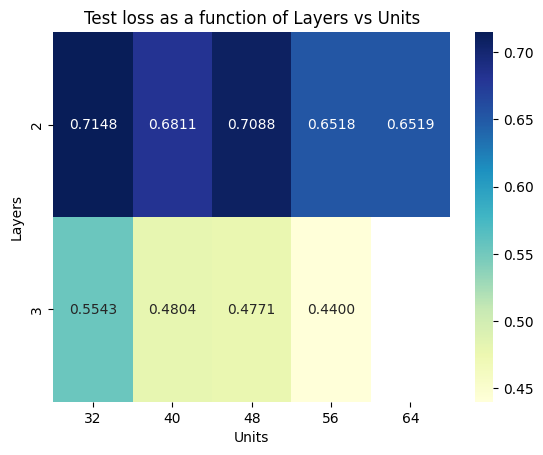

In [12]:
def read_mlflow_data(experiment_name):
    runs = mlflow.search_runs(experiment_ids=[experiment_name])
    return runs

mlflow_data = read_mlflow_data('3')

def create_heatmap_data(mlflow_data):
    heatmap_data = mlflow_data[['params.layers', 'params.units', 'metrics.Loss/test']]
    # Returns unique layers and units combinations whose loss value is lowest.
    heatmap_data = heatmap_data.loc[heatmap_data.groupby(['params.layers', 'params.units'])['metrics.Loss/test'].idxmin()]
    return heatmap_data

def plot_heatmap(heatmap_data):
    heatmap_pivot = heatmap_data.pivot(index='params.layers', columns='params.units', values='metrics.Loss/test')
    sns.heatmap(heatmap_pivot, annot=True, fmt=".4f", cmap="YlGnBu")
    plt.xlabel('Units')
    plt.ylabel('Layers')
    plt.title('Test loss as a function of Layers vs Units')
    plt.show()

heatmap_data = create_heatmap_data(mlflow_data)
plot_heatmap(heatmap_data)

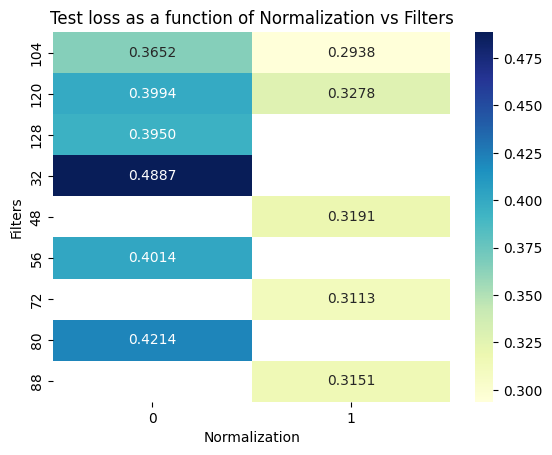

,params.filters,params.normalization,metrics.Loss/test
7,104,0,0.365175
10,104,1,0.293771
12,120,0,0.399406
1,120,1,0.327784
4,128,0,0.395012
6,32,0,0.488657
11,48,1,0.319097
5,56,0,0.401409
9,72,1,0.311332
8,80,0,0.421370


In [56]:
def read_mlflow_data(experiment_name):
    runs = mlflow.search_runs(experiment_ids=[experiment_name])
    return runs

mlflow_data = read_mlflow_data('3')

def create_heatmap_data(mlflow_data):
    heatmap_data = mlflow_data[['params.filters', 'params.normalization', 'metrics.Loss/test']]
    # Returns unique layers and units combinations whose loss value is lowest.
    heatmap_data = heatmap_data.dropna(subset=['params.filters', 'params.normalization'])
    heatmap_data = heatmap_data.loc[heatmap_data.groupby(['params.filters', 'params.normalization'])['metrics.Loss/test'].idxmin()]
    return heatmap_data

def plot_heatmap(heatmap_data):
    heatmap_pivot = heatmap_data.pivot(index='params.filters', columns='params.normalization', values='metrics.Loss/test')
    sns.heatmap(heatmap_pivot, annot=True, fmt=".4f", cmap="YlGnBu")
    plt.xlabel('Normalization')
    plt.ylabel('Filters')
    plt.title('Test loss as a function of Normalization vs Filters')
    plt.show()

heatmap_data = create_heatmap_data(mlflow_data)
plot_heatmap(heatmap_data)
heatmap_data

In [ ]:
def read_mlflow_data(experiment_name):
    runs = mlflow.search_runs(experiment_ids=[experiment_name])
    return runs

mlflow_data = read_mlflow_data('3')

def create_heatmap_data(mlflow_data):
    heatmap_data = mlflow_data[['params.filters', 'params.normalization', 'metrics.Loss/test']]
    # Returns unique layers and units combinations whose loss value is lowest.
    heatmap_data = heatmap_data.dropna(subset=['params.filters', 'params.normalization'])
    heatmap_data = heatmap_data.drop(index=heatmap_data[])
    return heatmap_data

heatmap_data = create_heatmap_data(mlflow_data)
heatmap_data